In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom as dcm
import os
import nibabel as nib
from tqdm import tqdm
from tensorflow import keras
from keras import layers, models
import tensorflow_io as tfio
import cv2
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import tensorflow_addons as tfa
import glob

In [3]:
def window_image(img, minn,maxx, intercept, slope, rescale=True):
    img = (img*slope +intercept) 
    
    img[img<minn] = minn 
    img[img>maxx] = maxx 
    if rescale: 
        img = (img - minn) / (maxx - minn)
    return img
    
def get_first_of_dicom_field_as_int(x):
    if type(x) == dcm.multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value,
                    data[('0028','1051')].value,
                    data[('0028','1052')].value,
                    data[('0028','1053')].value]
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [4]:
def channeling(img1, img2, img3):
    return np.stack([img1, img2, img3], axis=-1)

In [5]:
def load_image(path):
    data_path = '../../Downloads/rsna-2022-cervical-spine-fracture-detection/train_images/'
    UID = path.split('/')[-1][:-7]+"/"
    data = dcm.dcmread(data_path+UID+os.listdir(data_path+UID)[0])
    _, _, intercept, slope = get_windowing(data)
    img = nib.load(path)
    img = img.get_fdata()
    return img, intercept, slope

In [6]:
# def extract(path):
   
#     final_ct = load_image(path+"/"+"1.dcm").reshape(1,size,size)
#     for image in range(1, len(os.listdir(path))):
#         img = load_image(path+"/"+str(image)+".dcm").reshape(1,size,size)
#         final_ct = np.append(final_ct, img, axis=0)
        
#     resized_final_ct = cv2.resize(final_ct[:,:,0], (size,size)).reshape(1,size,size)
#     for i in range(1,final_ct.shape[1]):
#         resized_final_ct = np.append(resized_final_ct, cv2.resize(final_ct[:,:,i], (size,size)).reshape(1,size,size), axis=0)
  

#     return window(resized_final_ct)

In [2]:
bb_df = pd.read_csv("../../Downloads/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
df = pd.read_csv("../../Downloads/rsna-2022-cervical-spine-fracture-detection/train.csv")


In [3]:
bb_df[['x', 'y', 'width', 'height']] = (bb_df[['x', 'y', 'width', 'height']]//2).astype(int)

In [4]:
not_patients = df[df['patient_overall']==0]['StudyInstanceUID']

In [5]:
patients = bb_df['StudyInstanceUID'].unique()

In [6]:
not_patients

3       1.2.826.0.1.3680043.12351
7       1.2.826.0.1.3680043.17364
8         1.2.826.0.1.3680043.849
12      1.2.826.0.1.3680043.24946
13       1.2.826.0.1.3680043.9290
                  ...            
2011    1.2.826.0.1.3680043.32263
2012     1.2.826.0.1.3680043.6398
2013    1.2.826.0.1.3680043.31621
2016    1.2.826.0.1.3680043.14341
2017    1.2.826.0.1.3680043.12053
Name: StudyInstanceUID, Length: 1058, dtype: object

In [12]:
def get_slice_list(uid):
   final_list = set({})
   for i in range(bb_df[bb_df['StudyInstanceUID'] == uid].shape[0]):
      minn = bb_df[bb_df['StudyInstanceUID'] == uid].iloc[i]["x"]
      width = bb_df[bb_df['StudyInstanceUID'] == uid].iloc[i]["width"]
      slice_list = list(range(minn,minn+width+1))
      final_list.update(slice_list)
   return list(final_list)

In [194]:
path = '../storage/'
for patient in tqdm(patients):
    try:
        slices = get_slice_list(patient)
        ct,intercept,slope = load_image(path+patient+'.nii.gz')
        for slice in slices:
            img1 = window_image(ct[:,:,slice],100,600,intercept,slope)
            img2 = window_image(ct[:,:,slice],600,1100,intercept,slope)
            img3 = window_image(ct[:,:,slice],1100,1600,intercept,slope)
            img = channeling(img1,img2,img3)
            ni_img = nib.Nifti1Image(img, affine=np.eye(4))
            nib.save(ni_img, '../sagittal_positive_slices/'+patient+"."+str(slice) +".nii.gz")

    except:
        continue

100%|██████████| 125/125 [02:27<00:00,  1.18s/it]


In [195]:
path = '../storage/'
for patient in tqdm(not_patients):
    try:
        slices = list(range(80, 170,3))
        ct,intercept,slope = load_image(path+patient+'.nii.gz')
        for slice in slices:
            img1 = window_image(ct[:,:,slice],100,600,intercept,slope)
            img2 = window_image(ct[:,:,slice],600,1100,intercept,slope)
            img3 = window_image(ct[:,:,slice],1100,1600,intercept,slope)
            img = channeling(img1,img2,img3)
            ni_img = nib.Nifti1Image(img, affine=np.eye(4))
            nib.save(ni_img, '../sagittal_negative_slices/'+patient+"."+str(slice) +".nii.gz")

    except:
        continue

100%|██████████| 1058/1058 [13:43<00:00,  1.28it/s]


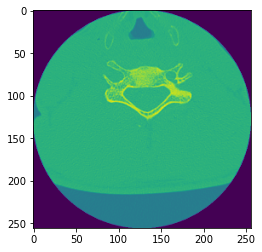

In [194]:
slice = nib.load('../storage/1.2.826.0.1.3680043.142.nii.gz')
slice = slice.get_fdata()
plt.imshow(slice[150])

In [7]:

positive_list = glob.glob('../sagittal_positive_slices/*')
negative_list = glob.glob('../sagittal_negative_slices/*')

pos_80 = int((len(positive_list)*4)//5)
neg_80 = int((len(negative_list)*4)//5)

train_positive_list = positive_list[:pos_80]
test_positive_list = positive_list[pos_80:]
train_negative_list = negative_list[:neg_80]
test_negative_list = negative_list[neg_80:]


train_positive_list.extend(train_negative_list)
test_positive_list.extend(test_negative_list)


final_train_list = np.random.choice(train_positive_list, size = len(train_positive_list), replace=False)
final_test_list = np.random.choice(test_positive_list, size = len(test_positive_list), replace=False)

In [8]:
def data_gen():
    for image in final_train_list:
        if image.split("_")[1] == "positive":
            uid = image.split('\\')[1]
            weired_len = 8 + len(uid.split('.')[-3])
            uid = uid[:-weired_len]
            pdf = df[df['StudyInstanceUID'] == uid]
            co = pdf['patient_overall'].values[0]
            c1 = pdf['C1'].values[0]
            c2 = pdf['C2'].values[0]
            c3 = pdf['C3'].values[0]
            c4 = pdf['C4'].values[0]
            c5 = pdf['C5'].values[0]
            c6 = pdf['C6'].values[0]
            c7 = pdf['C7'].values[0]
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                  {'co': co, 
                                        'c1': c1,
                                        'c2': c2,
                                        'c3': c3,
                                        'c4': c4,
                                        'c5': c5,
                                        'c6': c6,
                                        'c7': c7,},
                      {'co': 14, 
                                    'c1': 2,
                                    'c2': 2,
                                    'c3': 2,
                                    'c4': 2,
                                    'c5': 2,
                                    'c6': 2,
                                    'c7': 2})
        else:
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                {'co': 0, 
                                        'c1': 0,
                                        'c2': 0,
                                        'c3': 0,
                                        'c4': 0,
                                        'c5': 0,
                                        'c6': 0,
                                        'c7': 0,},
                      {'co': 7, 
                                    'c1': 1,
                                    'c2': 1,
                                    'c3': 1,
                                    'c4': 1,
                                    'c5': 1,
                                    'c6': 1,
                                    'c7': 1})

def test_gen():
    for image in final_test_list:
        if image.split("_")[1] == "positive":
            uid = image.split('\\')[1]
            weired_len = 8 + len(uid.split('.')[-3])
            uid = uid[:-weired_len]
            pdf = df[df['StudyInstanceUID'] == uid]
            co = pdf['patient_overall'].values[0]
            c1 = pdf['C1'].values[0]
            c2 = pdf['C2'].values[0]
            c3 = pdf['C3'].values[0]
            c4 = pdf['C4'].values[0]
            c5 = pdf['C5'].values[0]
            c6 = pdf['C6'].values[0]
            c7 = pdf['C7'].values[0]
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                  {'co': co, 
                                        'c1': c1,
                                        'c2': c2,
                                        'c3': c3,
                                        'c4': c4,
                                        'c5': c5,
                                        'c6': c6,
                                        'c7': c7,},
                      {'co': 14, 
                                    'c1': 2,
                                    'c2': 2,
                                    'c3': 2,
                                    'c4': 2,
                                    'c5': 2,
                                    'c6': 2,
                                    'c7': 2})
        else:
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                {'co': 0, 
                                        'c1': 0,
                                        'c2': 0,
                                        'c3': 0,
                                        'c4': 0,
                                        'c5': 0,
                                        'c6': 0,
                                        'c7': 0,},
                      {'co': 7, 
                                    'c1': 1,
                                    'c2': 1,
                                    'c3': 1,
                                    'c4': 1,
                                    'c5': 1,
                                    'c6': 1,
                                    'c7': 1})


In [9]:
dataset = tf.data.Dataset.from_generator(
     data_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8},
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8}),
    ({"input_1":tf.TensorShape([256,256,3])}, 
     {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])},
    {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])})
)

testset = tf.data.Dataset.from_generator(
     test_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8},
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8}),
    ({"input_1":tf.TensorShape([256,256,3])}, 
     {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])},
    {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])})
)

In [10]:
augment = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.3),
  keras.layers.GaussianNoise(0.1),
  keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=5),
  keras.layers.RandomContrast(0.1, seed=2),
  keras.layers.RandomZoom(
    (-0.2, 0.2),
    (-0.2, 0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=3)
])

In [11]:
dataset = dataset.map(lambda x, y, z: (augment(x['input_1']), y, z), 
              num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(15)
dataset = dataset.prefetch(1)


testset = testset.batch(15)
testset = testset.prefetch(1)

In [12]:
base = tf.keras.applications.ResNetRS50(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(256,256,3),
)

inputs = keras.Input((256, 256, 3), name = "input_1")
x = base(inputs)
x0 = tf.keras.layers.Dropout(0.7)(x)
x0 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x0)
x0 = tf.keras.layers.Dropout(0.5)(x0)
x0 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x0)
x0 = tf.keras.layers.Dropout(0.5)(x0)

x1 = tf.keras.layers.Dropout(0.7)(x)
x1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)
x1 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)

x2 = tf.keras.layers.Dropout(0.7)(x)
x2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x2)
x2 = tf.keras.layers.Dropout(0.5)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x2)
x2 = tf.keras.layers.Dropout(0.5)(x2)

x3 = tf.keras.layers.Dropout(0.7)(x)
x3 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x3)
x3 = tf.keras.layers.Dropout(0.5)(x3)
x3 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x3)
x3 = tf.keras.layers.Dropout(0.5)(x3)

x4 = tf.keras.layers.Dropout(0.7)(x)
x4 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x4)
x4 = tf.keras.layers.Dropout(0.5)(x4)
x4 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x4)
x4 = tf.keras.layers.Dropout(0.5)(x4)

x5 = tf.keras.layers.Dropout(0.7)(x)
x5 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x5)
x5 = tf.keras.layers.Dropout(0.5)(x5)
x5 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x5)
x5 = tf.keras.layers.Dropout(0.5)(x5)

x6 = tf.keras.layers.Dropout(0.7)(x)
x6 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x6)
x6 = tf.keras.layers.Dropout(0.5)(x6)
x6 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x6)
x6 = tf.keras.layers.Dropout(0.5)(x6)

x7 = tf.keras.layers.Dropout(0.7)(x)
x7 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x7)
x7 = tf.keras.layers.Dropout(0.5)(x7)
x7 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x7)
x7 = tf.keras.layers.Dropout(0.5)(x7)

outputo = keras.layers.Dense(1 ,activation = 'sigmoid', name="co")(x0)
output1 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c1")(x1)
output2 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c2")(x2)
output3 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c3")(x3)
output4 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c4")(x4)
output5 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c5")(x5)
output6 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c6")(x6)
output7 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c7")(x7)
                                               
model = keras.models.Model(inputs=inputs, outputs=[outputo,output1,output2,output3,output4,output5,output6,output7])

In [13]:
def lr_schedule(epoch, lr):
    return lr/(epoch+1)

In [20]:
opt = tfa.optimizers.AdamW(
    weight_decay=0,
    learning_rate = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07,
    name = 'AdamW',
)
loss = tf.keras.losses.BinaryCrossentropy(
    label_smoothing=0.2, 
    reduction=tf.keras.losses.Reduction.AUTO,
    name='binary_crossentropy'
)
metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
model.compile(optimizer=opt,
              loss={"co": loss, 
                   "c1": loss,
                   "c2": loss,
                   "c3": loss,
                   "c4": loss,
                   "c5": loss,
                   "c6": loss,
                   "c7": loss,},
                weighted_metrics={"co": metrics})

In [21]:
!mkdir best_weights

A subdirectory or file best_weights already exists.


In [22]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = './best_weights/model',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

In [23]:
history = model.fit(dataset, validation_data = testset, epochs=2, callbacks=[model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/2
2591/2591 [==============================] - 838s 316ms/step - loss: 11.6994 - co_loss: 6.5080 - c1_loss: 0.6862 - c2_loss: 0.7299 - c3_loss: 0.6805 - c4_loss: 0.7032 - c5_loss: 0.7502 - c6_loss: 0.7880 - c7_loss: 0.7845 - co_auc_1: 0.5496 - co_recall_1: 0.8735 - co_precision_1: 0.5302 - val_loss: 11.8692 - val_co_loss: 6.7601 - val_c1_loss: 0.6721 - val_c2_loss: 0.7178 - val_c3_loss: 0.6372 - val_c4_loss: 0.7420 - val_c5_loss: 0.7782 - val_c6_loss: 0.7729 - val_c7_loss: 0.7355 - val_co_auc_1: 0.4816 - val_co_recall_1: 0.0000e+00 - val_co_precision_1: 0.0000e+00 - lr: 0.0010
Epoch 2/2
2591/2591 [==============================] - 950s 367ms/step - loss: 11.4964 - co_loss: 6.4086 - c1_loss: 0.6778 - c2_loss: 0.7190 - c3_loss: 0.6627 - c4_loss: 0.6924 - c5_loss: 0.7389 - c6_loss: 0.7774 - c7_loss: 0.7778 - co_auc_1: 0.6118 - co_recall_1: 0.7383 - co_precision_1: 0.5785 - val_loss: 16.9863 - val_co_loss: 10.9423 - val_c1_loss: 0.7850 - val_c2_loss: 0.8799 - val_c3_loss: 0.6428 - 

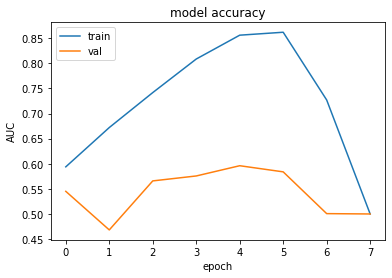

In [18]:
plt.plot(history.history['co_auc'])
plt.plot(history.history['val_co_auc'])
plt.title('model accuracy')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

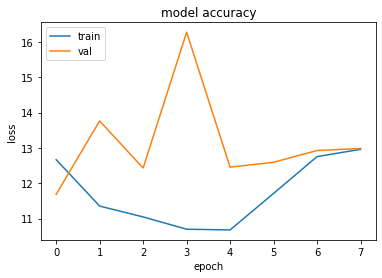

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('./best_weights/model')

In [210]:
model.evaluate(testset)

972/972 [==============================] - 86s 88ms/step - loss: 0.8776 - auc_14: 0.8055 - recall_1: 0.5958 - precision_1: 0.6619


[0.8775987029075623,
 0.8055421113967896,
 0.5957763195037842,
 0.6619299650192261]